<a href="https://colab.research.google.com/github/ChapelFob80930/AI-Generated-Text-Detector/blob/main/AITextTest2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing the Dataset**

In [2]:
import numpy as np
import pandas as pd

ai_generated_dataset = pd.read_csv("/content/train_v2_drcat_02.csv")
print(ai_generated_dataset.shape)
ai_generated_dataset = ai_generated_dataset.dropna()
ai_generated_dataset = ai_generated_dataset.drop(columns=['prompt_name','source','RDizzl3_seven'])
print(ai_generated_dataset.head())
print(ai_generated_dataset.shape)

(44868, 5)
                                                text  label
0  Phones\n\nModern humans today are always on th...      0
1  This essay will explain if drivers should or s...      0
2  Driving while the use of cellular devices\n\nT...      0
3  Phones & Driving\n\nDrivers should not be able...      0
4  Cell Phone Operation While Driving\n\nThe abil...      0
(44868, 2)


In [1]:
import nltk
nltk.download()


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_eng to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package averaged_perceptron_tagger_rus to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_rus.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_d


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> Q


True

In [ ]:
# import spacy
# nlp = spacy.load('en_core_web_sm')

# def lemmatize_text(text):
#   doc = nlp(" ".join(text))
#   return [token.lemma_ for token in doc]

In [ ]:
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')

# stop_words = set(stopwords.words('english'))

# def _remove_stopwords_(texts):
#   return [text for text in texts if text.isalnum() and text not in stop_words]

In [ ]:
# from nltk.tokenize import word_tokenize
# nltk.download('punkt')

# def preprocess_text(series):
#     def process(text):
#         tokens = word_tokenize(text)
#         tokens = _remove_stopwords_(tokens)
#         tokens = lemmatize_text(tokens)
#         return " ".join(tokens)
#     return series.apply(process)


#**Preprocessing Data**

In [3]:
import numpy as np
import pandas as pd
import spacy
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
import nltk
import re


nlp = spacy.load('en_core_web_sm')


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]","",text.lower())
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]
    return " ".join(tokens)


def parallel_preprocessing(series):
    """Preprocess text using spaCy, parallel processing, and tqdm for progress tracking."""
    tqdm.pandas()
    return Parallel(n_jobs=10, backend="multiprocessing")(delayed(preprocess)(text) for text in tqdm(series, desc="Preprocessing"))


ai_generated_dataset["preprocessedText"] = parallel_preprocessing(ai_generated_dataset["text"])

print(ai_generated_dataset.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing:   0%|          | 0/44868 [00:00<?, ?it/s]

                                                text  label  \
0  Phones\n\nModern humans today are always on th...      0   
1  This essay will explain if drivers should or s...      0   
2  Driving while the use of cellular devices\n\nT...      0   
3  Phones & Driving\n\nDrivers should not be able...      0   
4  Cell Phone Operation While Driving\n\nThe abil...      0   

                                    preprocessedText  
0  phone modern human today always phone always p...  
1  essay explain driver able use electronic devic...  
2  drive use cellular device today society though...  
3  phone drive driver able use phone operate vehi...  
4  cell phone operation drive ability stay connec...  


#**Creating Word2Vec Embeddings**

In [4]:
from gensim.models import Word2Vec

sentences = ai_generated_dataset["preprocessedText"].apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences, vector_size=300, window=10, min_count=2, workers=4, sg=1)

word_vector = word2vec_model.wv['car']
print("Vector for 'car':", word_vector)


def calculate_average_word_vector(words,model,vector_size=300):
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)

def parallel_word2vec(row):
    return calculate_average_word_vector(row.split(), word2vec_model)

# ai_generated_dataset['word2vecVector'] = ai_generated_dataset["preprocessedText"].apply(lambda x: calculate_average_word_vector(x.split(),word2vec_model))
ai_generated_dataset['word2vecVector'] = Parallel(n_jobs=10,backend='multiprocessing')(delayed(parallel_word2vec)(row) for row in tqdm(ai_generated_dataset["preprocessedText"], desc="Word2Vec"))
print(ai_generated_dataset.head())



Vector for 'car': [ 1.19117126e-02 -5.83535172e-02 -2.97238350e-01  2.74080932e-01
  2.02262327e-02  6.99392930e-02 -1.28757060e-01  8.21108073e-02
 -1.30847111e-01 -3.73637341e-02  1.08531095e-01 -5.30536333e-03
  2.02401187e-02 -1.31749347e-01 -2.77201861e-01  2.44644433e-01
  2.29364216e-01 -8.09386186e-03 -5.07123629e-03 -3.07619452e-01
  4.95574027e-01 -3.02679598e-01  2.14853197e-01  7.10112527e-02
 -1.92179665e-01  1.46416560e-01  6.85773939e-02  1.30423345e-02
  7.65489042e-02 -2.04294428e-01  1.53023899e-01  3.77675854e-02
 -1.35106340e-01  1.10432468e-01  1.21722259e-01 -2.03817859e-02
 -2.09298909e-01  8.01602080e-02 -8.89359042e-02 -3.34865879e-03
  7.34167993e-02  5.89143671e-02 -2.20366836e-01 -3.04642200e-01
  1.51060507e-01 -4.51166406e-02 -2.56074935e-01  3.28413039e-01
  3.59297991e-02 -2.75735199e-01  4.55544516e-02 -2.17938572e-01
 -3.04573327e-01  9.71338823e-02  1.59307614e-01  3.56768698e-01
 -2.77073681e-01 -3.83901328e-01 -8.74305889e-02  1.49075491e-02
  1.366

Word2Vec:   0%|          | 0/44868 [00:00<?, ?it/s]

                                                text  label  \
0  Phones\n\nModern humans today are always on th...      0   
1  This essay will explain if drivers should or s...      0   
2  Driving while the use of cellular devices\n\nT...      0   
3  Phones & Driving\n\nDrivers should not be able...      0   
4  Cell Phone Operation While Driving\n\nThe abil...      0   

                                    preprocessedText  \
0  phone modern human today always phone always p...   
1  essay explain driver able use electronic devic...   
2  drive use cellular device today society though...   
3  phone drive driver able use phone operate vehi...   
4  cell phone operation drive ability stay connec...   

                                      word2vecVector  
0  [0.08780912, 0.096668415, -0.046513904, 0.1391...  
1  [0.076874726, 0.10208669, -0.057527162, 0.1668...  
2  [0.07814441, 0.09636443, -0.05757494, 0.167942...  
3  [0.103549935, 0.15078086, -0.055593047, 0.1493...  
4  [0.149

#**Creating Doc2Vec Embeddings**

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


def prepare_tagged_documents(series):

    return [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(series)]


tqdm.pandas(desc="Preparing Tagged Documents")
tagged_data = prepare_tagged_documents(tqdm(ai_generated_dataset["preprocessedText"], desc="Tagging Data"))


doc2vec_model = Doc2Vec(tagged_data, vector_size=300, window=5, min_count=2, workers=4, dm=1,epochs=50)

# Function to generate Doc2Vec vectors
def generate_doc2vec_vector(index):

    return doc2vec_model.dv[str(index)]

# Use tqdm and joblib to parallelize vector generation
def generate_doc2vec_vectors_parallel(dataframe):

    indices = dataframe.index
    return Parallel(n_jobs=10, backend="multiprocessing")(delayed(generate_doc2vec_vector)(index) for index in tqdm(indices, desc="Generating Doc2Vec Vectors"))

ai_generated_dataset['doc2vecVector'] = generate_doc2vec_vectors_parallel(ai_generated_dataset)


print(ai_generated_dataset.head())


Tagging Data:   0%|          | 0/44868 [00:00<?, ?it/s]

Generating Doc2Vec Vectors:   0%|          | 0/44868 [00:00<?, ?it/s]

                                                text  label  \
0  Phones\n\nModern humans today are always on th...      0   
1  This essay will explain if drivers should or s...      0   
2  Driving while the use of cellular devices\n\nT...      0   
3  Phones & Driving\n\nDrivers should not be able...      0   
4  Cell Phone Operation While Driving\n\nThe abil...      0   

                                    preprocessedText  \
0  phone modern human today always phone always p...   
1  essay explain driver able use electronic devic...   
2  drive use cellular device today society though...   
3  phone drive driver able use phone operate vehi...   
4  cell phone operation drive ability stay connec...   

                                      word2vecVector  \
0  [0.08780912, 0.096668415, -0.046513904, 0.1391...   
1  [0.076874726, 0.10208669, -0.057527162, 0.1668...   
2  [0.07814441, 0.09636443, -0.05757494, 0.167942...   
3  [0.103549935, 0.15078086, -0.055593047, 0.1493...   
4  [

In [ ]:
# print(train_essays.head())

In [ ]:
# from sklearn.model_selection import train_test_split

# y = train_essays['generated']

# train_index, test_index = train_test_split(train_essays.index, test_size=0.2, random_state=42)

#**Splitting the Test and Train indexes and Separating the Labels from the Data**

In [ ]:
from sklearn.model_selection import train_test_split

y = ai_generated_dataset['label']

train_index, test_index = train_test_split(ai_generated_dataset.index, test_size=0.3, random_state=42, stratify = y)


In [ ]:
print(train_index.shape)
print(test_index.shape)

In [ ]:
# from sklearn.model_selection import train_test_split

# y = ai_human_dataset['generated']

# train_index, test_index = train_test_split(ai_human_dataset.index, test_size=0.2, random_state=42)

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(max_features=1000)
# X_tfidf = tfidf_vectorizer.fit_transform(train_essays['preprocessedText'])

# X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
# y_train, y_test = y[train_index], y[test_index]


#**Creating TF-IDF Embeddings**

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,3),max_df=0.95,min_df=2,sublinear_tf=True)
X_tfidf = tfidf_vectorizer.fit_transform(ai_generated_dataset["preprocessedText"])

X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
y_train, y_test = y[train_index], y[test_index]


In [9]:
print(X_train_tfidf.shape)

(31407, 5000)


In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_tfidf_balanced, y_train_tfidf_balanced = smote.fit_resample(X_train_tfidf, y_train)
print("TF-IDF Before SMOTE: ",dict(zip(*np.unique(y_train, return_counts=True))))
print("TF-IDF After SMOTE: ",dict(zip(*np.unique(y_train_tfidf_balanced, return_counts=True))))

TF-IDF Before SMOTE:  {0: 19159, 1: 12248}
TF-IDF After SMOTE:  {0: 19159, 1: 19159}


#**Splitting Word2Vec Embeddings into Train and Test Datasets**

In [11]:
ai_generated_dataset['word2vecVector'] = ai_generated_dataset['word2vecVector'].apply(lambda x: np.array(x))

X_word2vec = np.stack(ai_generated_dataset['word2vecVector'].values)

X_train_word2vec, X_test_word2vec = X_word2vec[train_index], X_word2vec[test_index]

print(X_train_word2vec.shape)
print(X_test_word2vec.shape)
print(X_train_word2vec)

(31407, 300)
(13461, 300)
[[ 1.9386718e-01  1.8212025e-01  1.3421586e-01 ...  1.3818129e-02
   1.0275673e-01 -1.2613804e-02]
 [ 1.4273715e-01  1.6095709e-02  5.7663903e-05 ... -4.1719958e-02
   2.2528203e-01 -1.0470055e-01]
 [ 2.5022781e-02  1.1228727e-01 -4.9039297e-02 ...  1.1154036e-03
   1.0737024e-01  1.6504792e-02]
 ...
 [ 6.1415557e-02  1.9116952e-01 -8.9191251e-02 ...  2.5655758e-02
   1.5532374e-01  6.0376646e-03]
 [ 7.9557717e-02  1.1973411e-01 -7.0516005e-02 ... -7.7403095e-03
   1.7649007e-01 -1.4039224e-02]
 [ 9.9566981e-02  1.7662083e-01 -7.0863709e-02 ...  2.0863282e-02
   1.7530334e-01  3.4500733e-02]]


In [12]:
X_train_word2vec_balanced, y_train_word2vec_balanced = smote.fit_resample(X_train_word2vec, y_train)
print("Word2Vec Before SMOTE: ",dict(zip(*np.unique(y_train, return_counts=True))))
print("Word2Vec After SMOTE: ",dict(zip(*np.unique(y_train_word2vec_balanced, return_counts=True))))

Word2Vec Before SMOTE:  {0: 19159, 1: 12248}
Word2Vec After SMOTE:  {0: 19159, 1: 19159}


#**Splitting Doc2Vec Embeddings into Train and Test Datasets**

In [13]:
ai_generated_dataset['doc2vecVector'] = ai_generated_dataset['doc2vecVector'].apply(lambda x: np.array(x))
X_doc2vec = np.stack(ai_generated_dataset['doc2vecVector'].values)
X_train_doc2vec, X_test_doc2vec = X_doc2vec[train_index], X_doc2vec[test_index]
print(X_train_doc2vec.shape)
print(X_test_doc2vec.shape)
print(X_train_doc2vec)

(31407, 300)
(13461, 300)
[[ 0.68442076 -0.48760787 -0.02157056 ...  0.35724998  0.5213385
  -1.078774  ]
 [ 0.23340839  0.8104108  -0.34742355 ...  0.2957258  -0.53912884
  -1.2756349 ]
 [-0.05841934 -0.59332186  0.56811625 ... -0.73445684  0.41304773
   0.4260478 ]
 ...
 [-0.13272572 -0.19603026 -1.0907412  ... -1.3491739  -0.09674363
  -0.3507875 ]
 [ 0.61315656  0.8993393   2.6859045  ... -0.7525959  -1.4770358
  -1.6349118 ]
 [-0.1151266  -0.9015243  -0.37618634 ... -0.03176318  0.24084964
   0.4837716 ]]


In [14]:
X_train_doc2vec_balanced, y_train_doc2vec_balanced = smote.fit_resample(X_train_doc2vec, y_train)
print("Doc2Vec Before SMOTE: ",dict(zip(*np.unique(y_train, return_counts=True))))
print("Doc2Vec After SMOTE: ",dict(zip(*np.unique(y_train_doc2vec_balanced, return_counts=True))))

Doc2Vec Before SMOTE:  {0: 19159, 1: 12248}
Doc2Vec After SMOTE:  {0: 19159, 1: 19159}


#**Implementing SVM on Different Types of Embeddings and Comparing Results**

#**Implementing Decision Tree on Different Types of Embeddings and Comparing Results**

#**Implementing Random Forest on Different Types of Embeddings and Comparing Results**

#**Implementing KNN on Different Types of Embeddings and Comparing Results**

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def evaluate_model_with_visualizations(model, X_train, X_test, y_train, y_test, model_name, embedding_name):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print(f"Performing 5-Fold Cross-Validation for {model_name} with {embedding_name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    print(f"{model_name} with {embedding_name} - Cross-validation Scores: {cv_scores}")
    print(f"{model_name} with {embedding_name} - Mean CV Accuracy: {cv_scores.mean():.4f}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name} with {embedding_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"{model_name} with {embedding_name} - Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(y_test)), y_test, alpha=0.6, label='Actual')
    plt.scatter(range(len(y_pred)), y_pred, alpha=0.6, label='Predicted', marker='x')
    plt.title(f'Scatter Plot: {model_name} with {embedding_name}')
    plt.xlabel('Sample Index')
    plt.ylabel('Labels')
    plt.legend()
    plt.show()

In [16]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# svm_param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': [0.01, 0.1, 1]
# }

# dt_param_grid = {
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }

# rf_param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }

# knn_param_grid = {
#     'n_neighbors': [3, 5, 7],
#     'weights': ['uniform', 'distance']
# }

In [17]:
print(ai_generated_dataset['label'].value_counts(normalize=True))

label
0    0.610034
1    0.389966
Name: proportion, dtype: float64


In [ ]:
svm_model_tfidf = SVC(class_weight='balanced',random_state=42,kernel='rbf',gamma='scale',C=1)
evaluate_model_with_visualizations(svm_model_tfidf, X_train_tfidf_balanced, X_test_tfidf, y_train_tfidf_balanced, y_test, "SVM", "TF-IDF")

Performing 10-Fold Cross-Validation for SVM with TF-IDF...


In [ ]:
svm_model_word2vec = SVC(class_weight='balanced',random_state=42, C=1, kernel='rbf', gamma='scale')
evaluate_model_with_visualizations(svm_model_word2vec, X_train_word2vec_balanced, X_test_word2vec, y_train_word2vec_balanced, y_test, "SVM", "Word2Vec")

In [ ]:
svm_model_doc2vec = SVC(class_weight='balanced',random_state=42, C=1, kernel='rbf', gamma='scale')
evaluate_model_with_visualizations(svm_model_doc2vec, X_train_doc2vec_balanced, X_test_doc2vec, y_train_doc2vec_balanced, y_test, "SVM", "Doc2Vec")

Performing 10-Fold Cross-Validation for Decision Tree with TF-IDF...
Decision Tree with TF-IDF - Cross-validation Scores: [0.94128392 0.93763048 0.93136743 0.93188935 0.93658664 0.93449896
 0.93241127 0.93345511 0.9412686  0.93265466]
Decision Tree with TF-IDF - Mean CV Accuracy: 0.9353


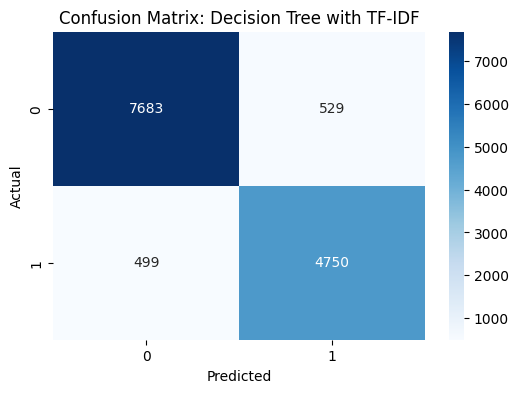

Decision Tree with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8212
           1       0.90      0.90      0.90      5249

    accuracy                           0.92     13461
   macro avg       0.92      0.92      0.92     13461
weighted avg       0.92      0.92      0.92     13461



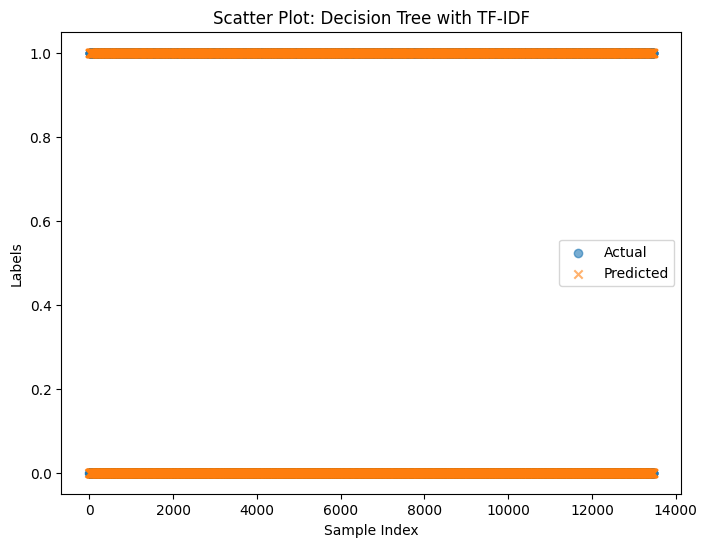

In [ ]:
decision_tree_model_tfidf = DecisionTreeClassifier(class_weight='balanced',random_state=42, criterion='gini',max_depth=None,min_samples_split=5)
evaluate_model_with_visualizations(decision_tree_model_tfidf, X_train_tfidf_balanced, X_test_tfidf, y_train_tfidf_balanced, y_test, "Decision Tree", "TF-IDF")

Performing 10-Fold Cross-Validation for Decision Tree with Word2Vec...
Decision Tree with Word2Vec - Cross-validation Scores: [0.94441545 0.93763048 0.94493737 0.94154489 0.94676409 0.95120042
 0.94572025 0.94780793 0.95327591 0.94648917]
Decision Tree with Word2Vec - Mean CV Accuracy: 0.9460


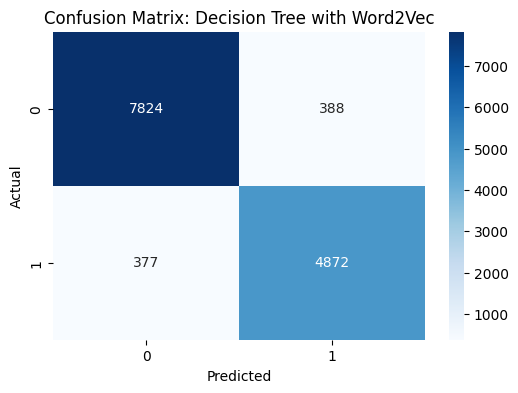

Decision Tree with Word2Vec - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8212
           1       0.93      0.93      0.93      5249

    accuracy                           0.94     13461
   macro avg       0.94      0.94      0.94     13461
weighted avg       0.94      0.94      0.94     13461



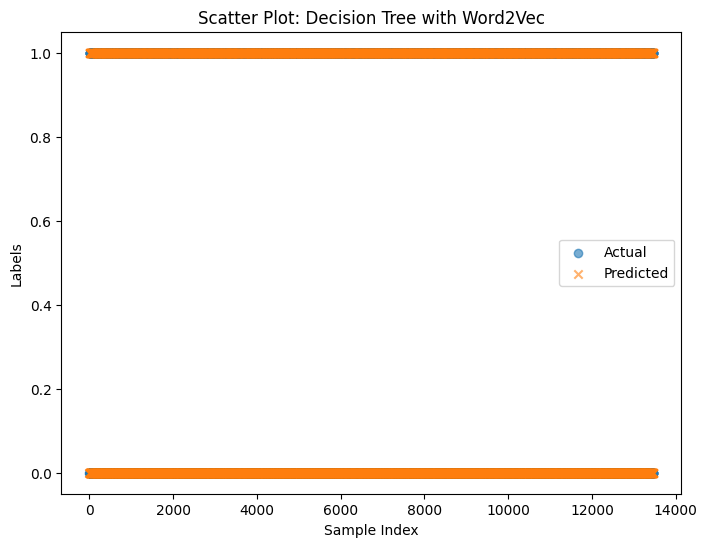

In [ ]:
decision_tree_model_word2vec = DecisionTreeClassifier(class_weight='balanced',random_state=42, criterion='gini', max_depth=None, min_samples_split=5)
evaluate_model_with_visualizations(decision_tree_model_word2vec, X_train_word2vec_balanced, X_test_word2vec, y_train_word2vec_balanced, y_test, "Decision Tree", "Word2Vec")

Performing 10-Fold Cross-Validation for Decision Tree with Doc2Vec...
Decision Tree with Doc2Vec - Cross-validation Scores: [0.66231733 0.66101253 0.63700418 0.65501044 0.66231733 0.65814196
 0.66205637 0.66362213 0.67006004 0.66718872]
Decision Tree with Doc2Vec - Mean CV Accuracy: 0.6599


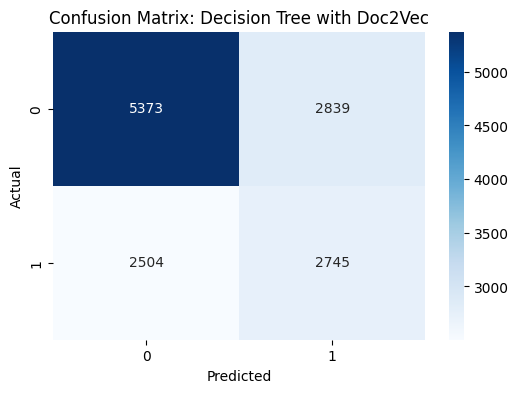

Decision Tree with Doc2Vec - Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.67      8212
           1       0.49      0.52      0.51      5249

    accuracy                           0.60     13461
   macro avg       0.59      0.59      0.59     13461
weighted avg       0.61      0.60      0.61     13461



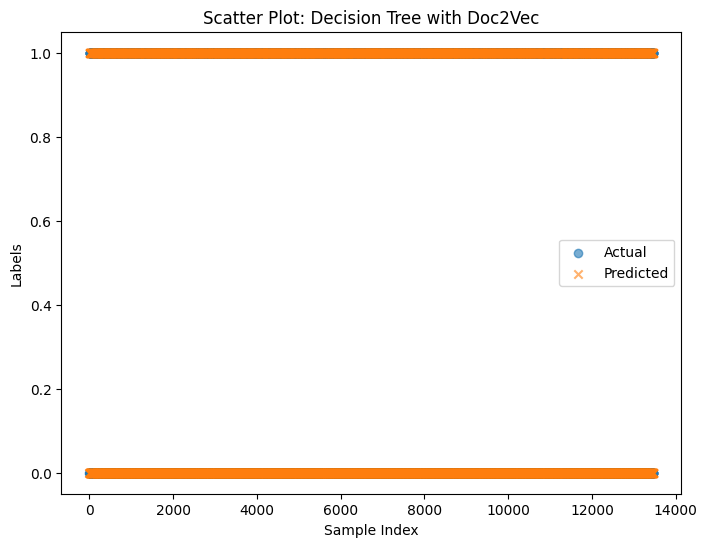

In [ ]:
decision_tree_model_doc2vec = DecisionTreeClassifier(class_weight='balanced',random_state=42, max_depth=None, min_samples_split=5)
evaluate_model_with_visualizations(decision_tree_model_doc2vec, X_train_doc2vec_balanced, X_test_doc2vec, y_train_doc2vec_balanced, y_test, "Decision Tree", "Doc2Vec")

Performing 10-Fold Cross-Validation for Random Forest with TF-IDF...
Random Forest with TF-IDF - Cross-validation Scores: [0.98903967 0.98956159 0.98695198 0.98590814 0.99138831 0.99112735
 0.98825678 0.98903967 0.98929783 0.98877578]
Random Forest with TF-IDF - Mean CV Accuracy: 0.9889


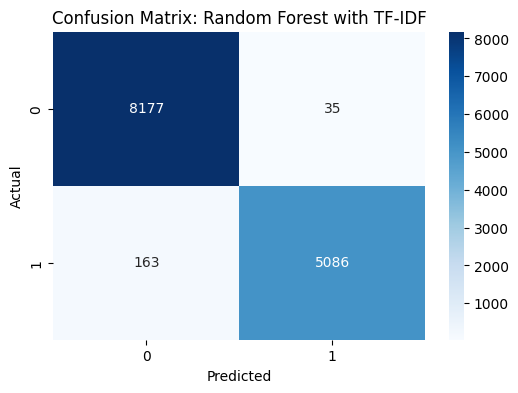

Random Forest with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8212
           1       0.99      0.97      0.98      5249

    accuracy                           0.99     13461
   macro avg       0.99      0.98      0.98     13461
weighted avg       0.99      0.99      0.99     13461



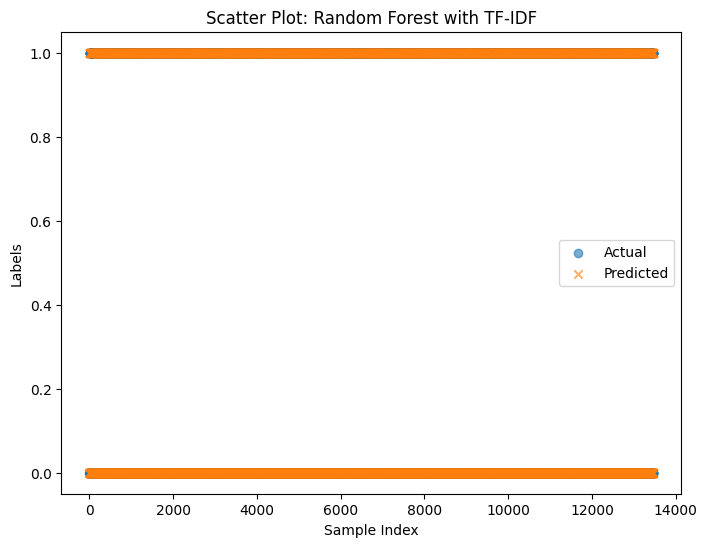

In [ ]:
random_forest_model_tfidf = RandomForestClassifier(class_weight='balanced', random_state=42,n_estimators=200,max_depth=None,min_samples_split=5)
evaluate_model_with_visualizations(random_forest_model_tfidf, X_train_tfidf_balanced, X_test_tfidf, y_train_tfidf_balanced, y_test, "Random Forest", "TF-IDF")

Performing 10-Fold Cross-Validation for Random Forest with Word2Vec...
Random Forest with Word2Vec - Cross-validation Scores: [0.98721294 0.9861691  0.9874739  0.98956159 0.98877871 0.98903967
 0.98564718 0.98669102 0.98929783 0.98877578]
Random Forest with Word2Vec - Mean CV Accuracy: 0.9879


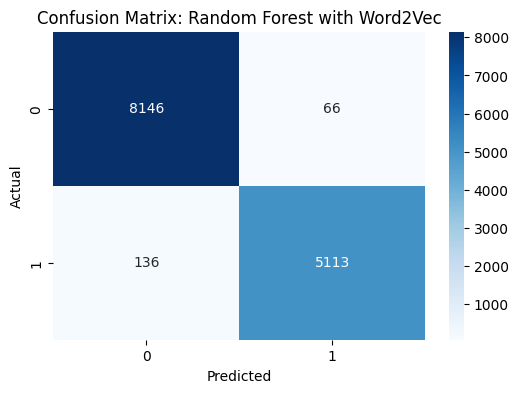

Random Forest with Word2Vec - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8212
           1       0.99      0.97      0.98      5249

    accuracy                           0.98     13461
   macro avg       0.99      0.98      0.98     13461
weighted avg       0.99      0.98      0.98     13461



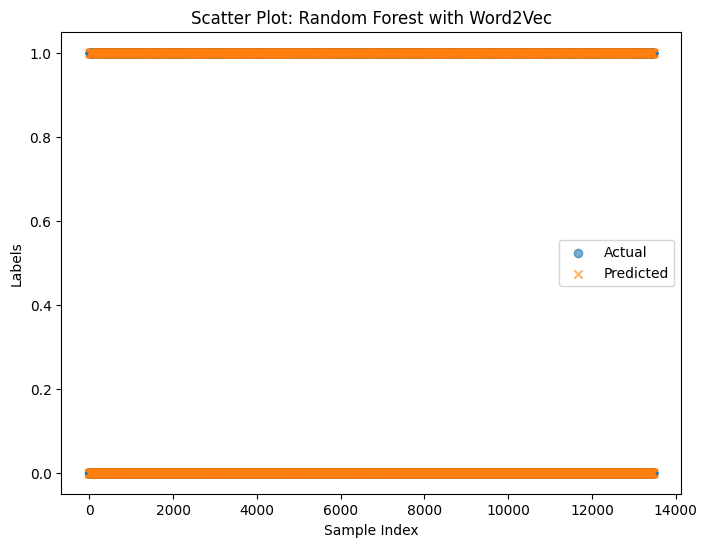

In [ ]:
random_forest_model_word2vec = RandomForestClassifier(class_weight='balanced',random_state=42, n_estimators=200, max_depth=None, min_samples_split=5)
evaluate_model_with_visualizations(random_forest_model_word2vec, X_train_word2vec_balanced, X_test_word2vec, y_train_word2vec_balanced, y_test, "Random Forest", "Word2Vec")

Performing 10-Fold Cross-Validation for Random Forest with Doc2Vec...
Random Forest with Doc2Vec - Cross-validation Scores: [0.81263048 0.80715031 0.80167015 0.80897704 0.80741127 0.81132568
 0.809238   0.8256785  0.81232054 0.81388671]
Random Forest with Doc2Vec - Mean CV Accuracy: 0.8110


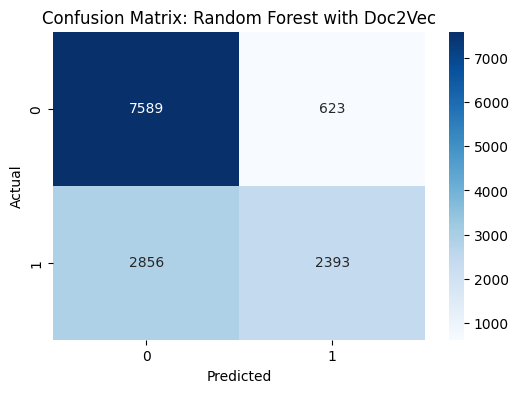

Random Forest with Doc2Vec - Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      8212
           1       0.79      0.46      0.58      5249

    accuracy                           0.74     13461
   macro avg       0.76      0.69      0.70     13461
weighted avg       0.75      0.74      0.72     13461



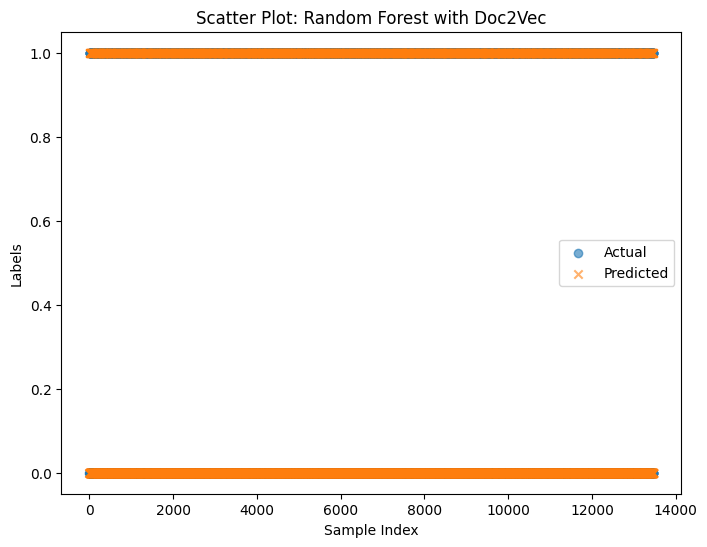

In [ ]:
random_forest_model_doc2vec = RandomForestClassifier(class_weight='balanced',random_state=42, n_estimators=200, max_depth=None, min_samples_split=5)
evaluate_model_with_visualizations(random_forest_model_doc2vec, X_train_doc2vec_balanced, X_test_doc2vec, y_train_doc2vec_balanced, y_test, "Random Forest", "Doc2Vec")

Performing 5-Fold Cross-Validation for KNN with TF-IDF...
KNN with TF-IDF - Cross-validation Scores: [0.97481733 0.96920668 0.97703549 0.97181261 0.97403106]
KNN with TF-IDF - Mean CV Accuracy: 0.9734


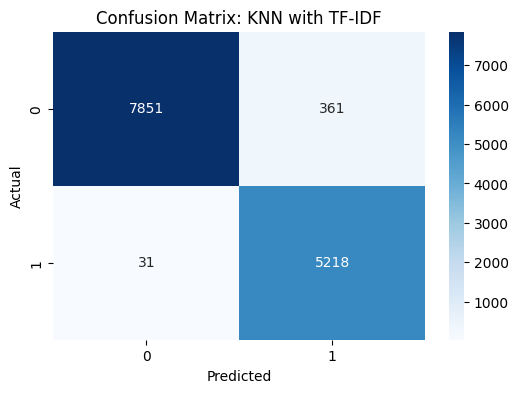

KNN with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8212
           1       0.94      0.99      0.96      5249

    accuracy                           0.97     13461
   macro avg       0.97      0.98      0.97     13461
weighted avg       0.97      0.97      0.97     13461



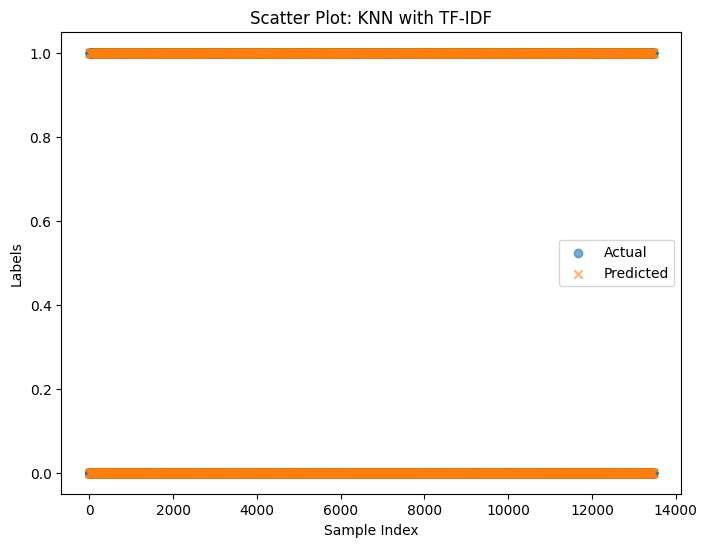

Performing 5-Fold Cross-Validation for KNN with TF-IDF...
KNN with TF-IDF - Cross-validation Scores: [0.97481733 0.96920668 0.97703549 0.97181261 0.97403106]
KNN with TF-IDF - Mean CV Accuracy: 0.9734


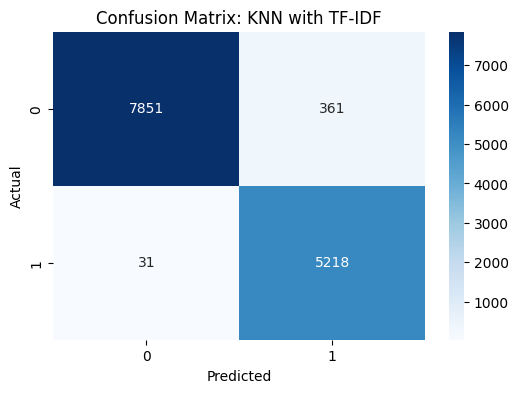

KNN with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8212
           1       0.94      0.99      0.96      5249

    accuracy                           0.97     13461
   macro avg       0.97      0.98      0.97     13461
weighted avg       0.97      0.97      0.97     13461



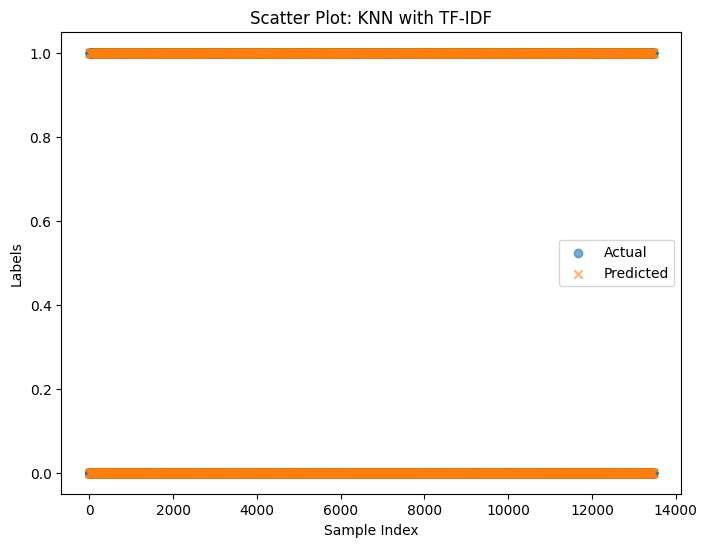

Performing 5-Fold Cross-Validation for KNN with TF-IDF...
KNN with TF-IDF - Cross-validation Scores: [0.97729645 0.97377349 0.97951461 0.97703249 0.97820697]
KNN with TF-IDF - Mean CV Accuracy: 0.9772


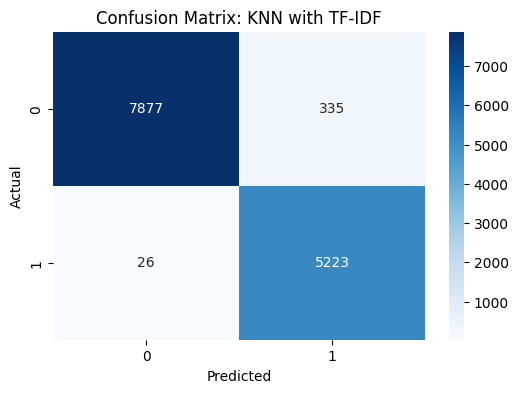

KNN with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8212
           1       0.94      1.00      0.97      5249

    accuracy                           0.97     13461
   macro avg       0.97      0.98      0.97     13461
weighted avg       0.97      0.97      0.97     13461



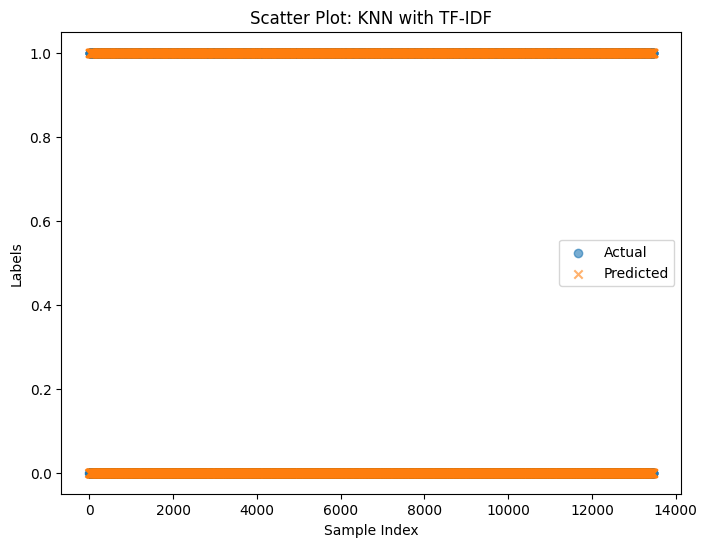

Performing 5-Fold Cross-Validation for KNN with TF-IDF...
KNN with TF-IDF - Cross-validation Scores: [0.97807933 0.97481733 0.97912317 0.97729349 0.97794597]
KNN with TF-IDF - Mean CV Accuracy: 0.9775


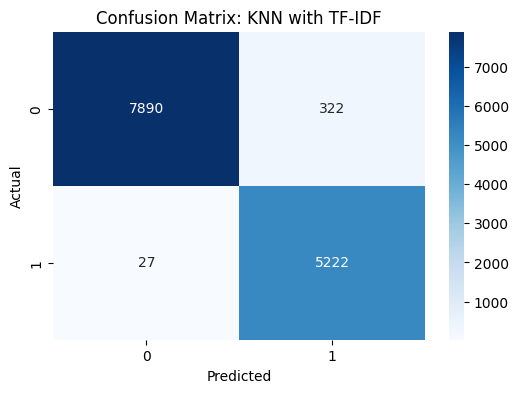

KNN with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8212
           1       0.94      0.99      0.97      5249

    accuracy                           0.97     13461
   macro avg       0.97      0.98      0.97     13461
weighted avg       0.98      0.97      0.97     13461



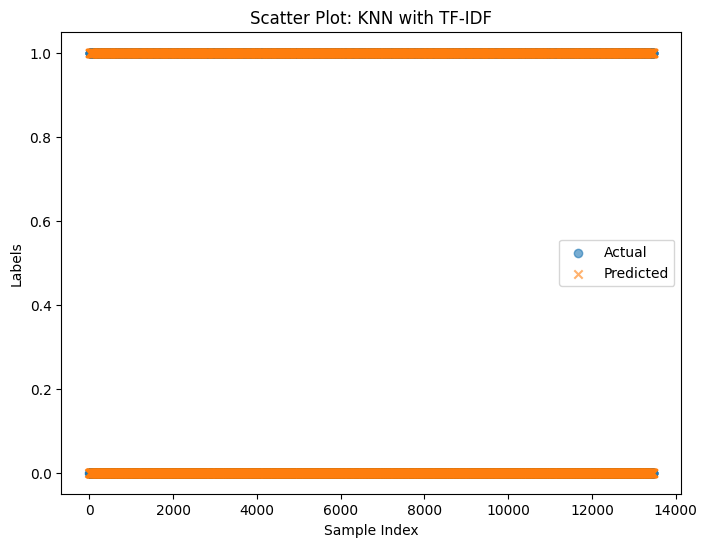

Performing 5-Fold Cross-Validation for KNN with TF-IDF...
KNN with TF-IDF - Cross-validation Scores: [0.98029749 0.97781837 0.98199374 0.97925095 0.98094741]
KNN with TF-IDF - Mean CV Accuracy: 0.9801


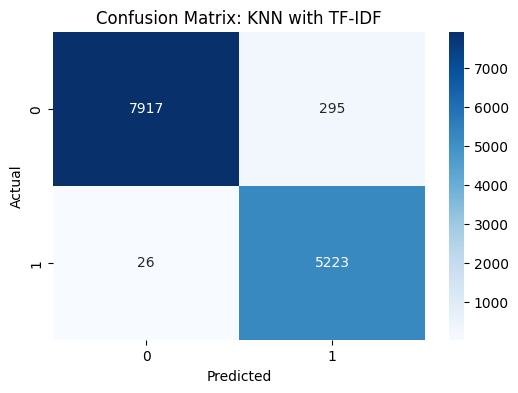

KNN with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8212
           1       0.95      1.00      0.97      5249

    accuracy                           0.98     13461
   macro avg       0.97      0.98      0.98     13461
weighted avg       0.98      0.98      0.98     13461



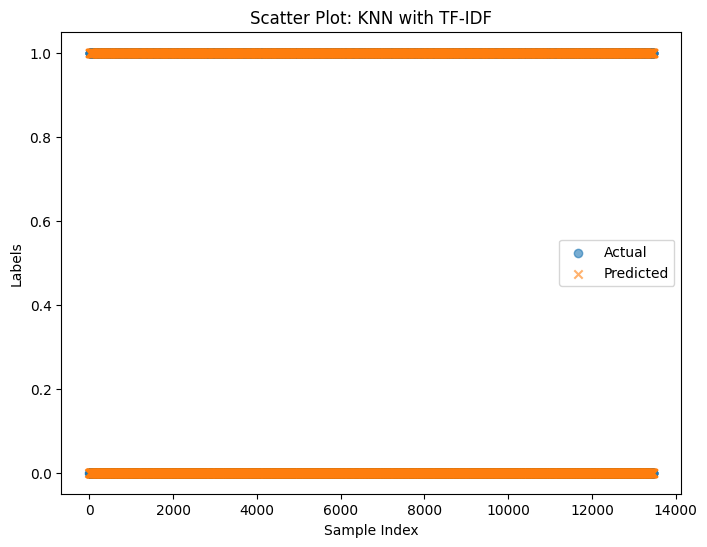

Performing 5-Fold Cross-Validation for KNN with TF-IDF...
KNN with TF-IDF - Cross-validation Scores: [0.9809499  0.97755741 0.9822547  0.97885945 0.98107791]
KNN with TF-IDF - Mean CV Accuracy: 0.9801


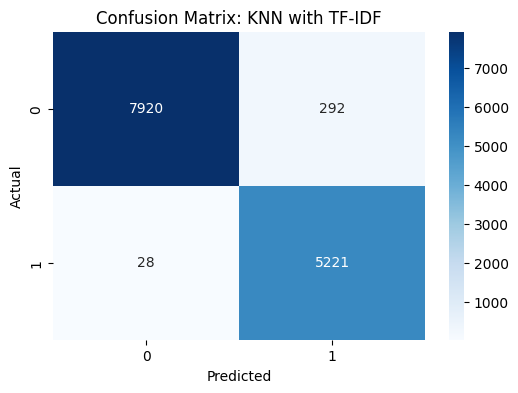

KNN with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8212
           1       0.95      0.99      0.97      5249

    accuracy                           0.98     13461
   macro avg       0.97      0.98      0.98     13461
weighted avg       0.98      0.98      0.98     13461



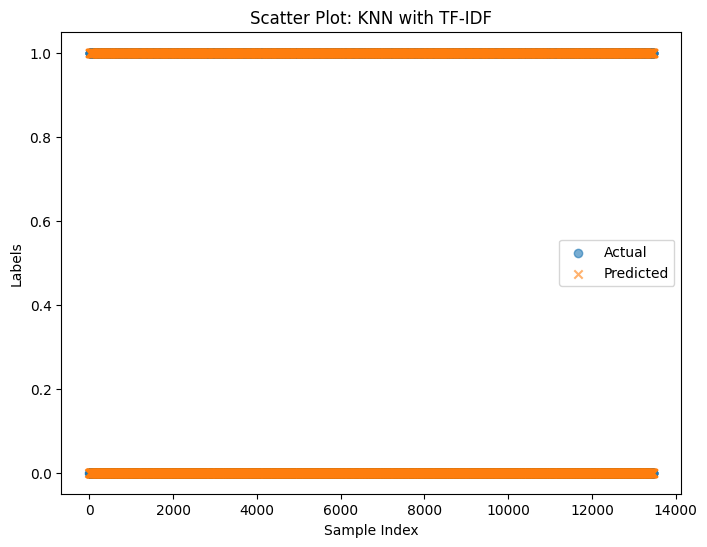

Performing 5-Fold Cross-Validation for KNN with TF-IDF...
KNN with TF-IDF - Cross-validation Scores: [0.98303758 0.97847077 0.98316806 0.98016443 0.98003393]
KNN with TF-IDF - Mean CV Accuracy: 0.9810


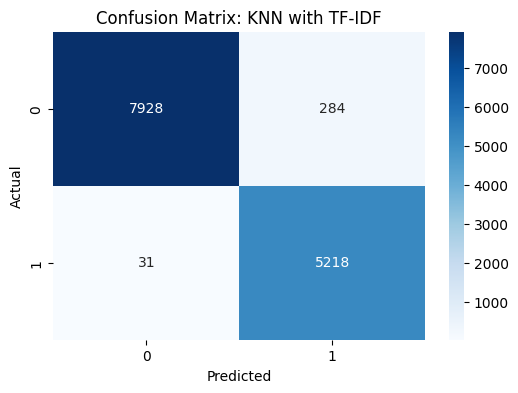

KNN with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8212
           1       0.95      0.99      0.97      5249

    accuracy                           0.98     13461
   macro avg       0.97      0.98      0.98     13461
weighted avg       0.98      0.98      0.98     13461



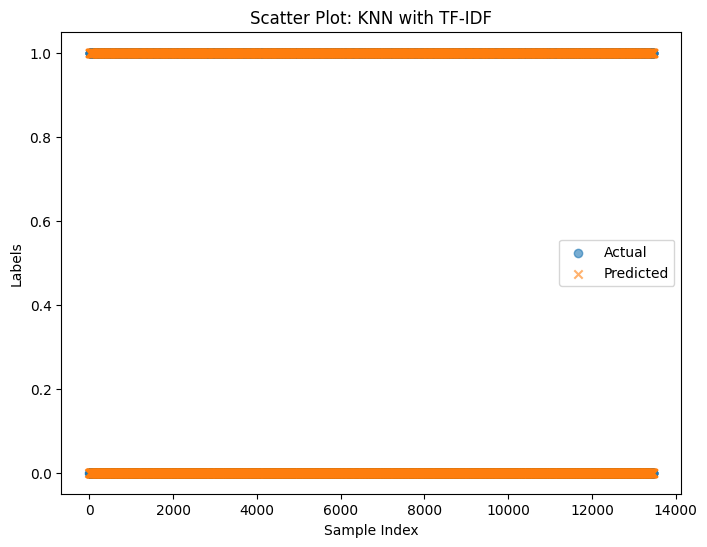

Performing 5-Fold Cross-Validation for KNN with TF-IDF...
KNN with TF-IDF - Cross-validation Scores: [0.9829071  0.97886221 0.98342902 0.98094741 0.98094741]
KNN with TF-IDF - Mean CV Accuracy: 0.9814


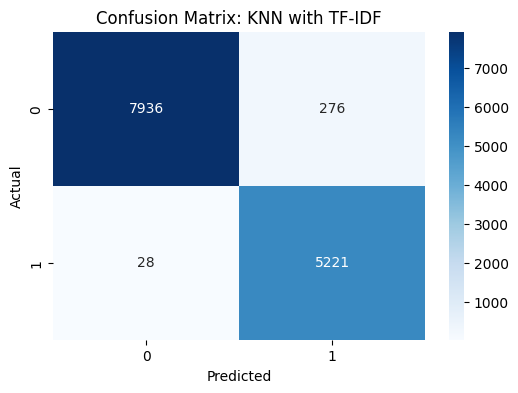

KNN with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8212
           1       0.95      0.99      0.97      5249

    accuracy                           0.98     13461
   macro avg       0.97      0.98      0.98     13461
weighted avg       0.98      0.98      0.98     13461



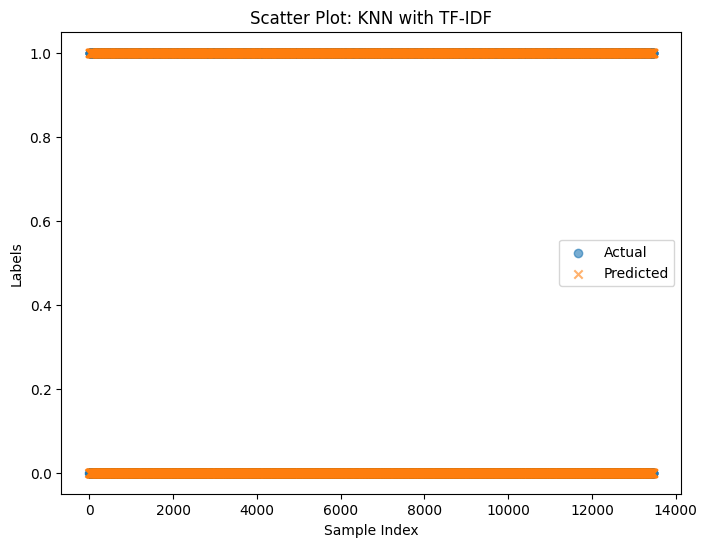

Performing 5-Fold Cross-Validation for KNN with TF-IDF...
KNN with TF-IDF - Cross-validation Scores: [0.98277662 0.97977557 0.98303758 0.98068642 0.98107791]
KNN with TF-IDF - Mean CV Accuracy: 0.9815


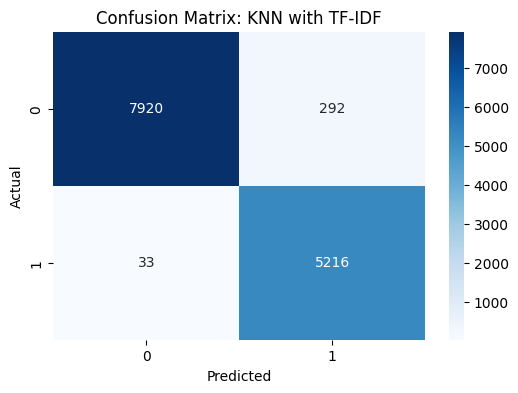

KNN with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8212
           1       0.95      0.99      0.97      5249

    accuracy                           0.98     13461
   macro avg       0.97      0.98      0.97     13461
weighted avg       0.98      0.98      0.98     13461



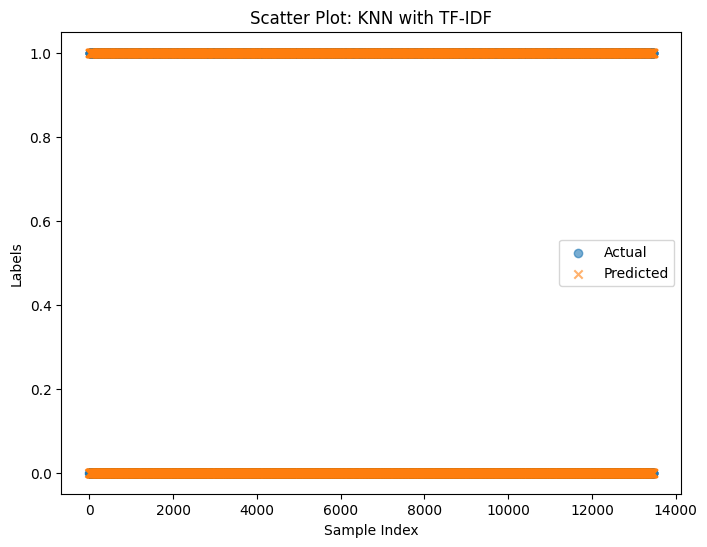

Performing 5-Fold Cross-Validation for KNN with TF-IDF...
KNN with TF-IDF - Cross-validation Scores: [0.98329854 0.97990605 0.9835595  0.98173039 0.98094741]
KNN with TF-IDF - Mean CV Accuracy: 0.9819


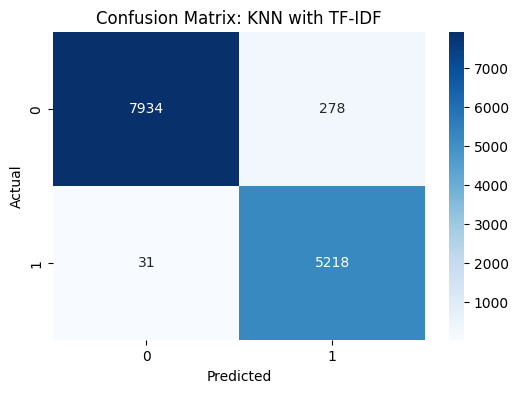

KNN with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8212
           1       0.95      0.99      0.97      5249

    accuracy                           0.98     13461
   macro avg       0.97      0.98      0.98     13461
weighted avg       0.98      0.98      0.98     13461



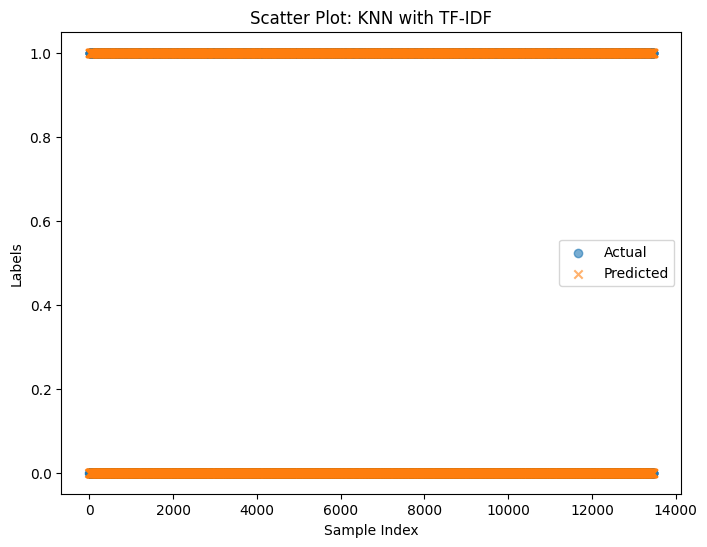

KeyboardInterrupt: 

In [18]:
error_rate = []
for n in range(1,11):
  knn_model_tfidf = KNeighborsClassifier(n_neighbors=n,weights='distance',metric='cosine')
  evaluate_model_with_visualizations(knn_model_tfidf, X_train_tfidf_balanced, X_test_tfidf, y_train_tfidf_balanced, y_test, "KNN", "TF-IDF")
  knn_model_tfidf.score(X_test_tfidf,y_test)
  error_rate.append(1-knn_model_tfidf.score(X_test_tfidf,y_test))
plt.plot(error_rate)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

In [ ]:
error_rate = []
for n in range(1,11):
  knn_model_word2vec = KNeighborsClassifier(n_neighbors=n,weights='distance',metric='cosine')
  evaluate_model_with_visualizations(knn_model_word2vec, X_train_word2vec_balanced, X_test_word2vec, y_train_word2vec_balanced, y_test, "KNN", "Word2Vec")
  knn_model_word2vec.score(X_test_word2vec,y_test)
  error_rate.append(1-knn_model_word2vec.score(X_test_word2vec,y_test))
plt.plot(error_rate)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

In [ ]:
error_rate = []
for n in range(1,11):
  knn_model_doc2vec = KNeighborsClassifier(n_neighbors=n,weights='distance',metric='cosine')
  evaluate_model_with_visualizations(knn_model_doc2vec, X_train_doc2vec_balanced, X_test_doc2vec, y_train_doc2vec_balanced, y_test, "KNN", "Doc2Vec")
  knn_model_doc2vec.score(X_test_doc2vec,y_test)
  error_rate.append(1-knn_model_doc2vec.score(X_test_doc2vec,y_test))
plt.plot(error_rate)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

#**Implementing the best embedding technique for each model and using it on custom data**


#1.   SVM :- TF-IDF
#2.   Decision Tree :- Word2Vec
#3.   Random Forest :- TF-IDF
#4.   KNN :- Word2Vec  



In [ ]:
# svm_model = SVC(class_weight='balanced',random_state=42)
# svm_model.fit(X_train_tfidf, y_train)

# decision_tree_model = DecisionTreeClassifier(random_state=42)
# decision_tree_model.fit(X_train_word2vec, y_train)

# random_forest_model = RandomForestClassifier(random_state=42)
# random_forest_model.fit(X_train_tfidf, y_train)

# knn_model = KNeighborsClassifier(n_neighbors=3)
# knn_model.fit(X_train_word2vec, y_train)

In [ ]:
custom_data = input()
#custom_data = "Good Morning Everyone, I am your teacher for today"
preprocessed_custom_data = preprocess(custom_data)
print(preprocessed_custom_data)
#for word in preprocessed_custom_data.split():
#    if word not in word2vec_model.wv:
#        print(f"Missing word: {word}")

custom_data_tfidf = tfidf_vectorizer.transform([preprocessed_custom_data])

#def update_word2vec_with_custom_data(preprocessed_data, word2vec_model):
#    """Updating Word2Vec model with custom data if new words are found."""
#    new_sentences = [preprocessed_data.split()]

#    word2vec_model.build_vocab(new_sentences, update=True)
#    word2vec_model.train(new_sentences, total_examples=len(new_sentences), epochs=5)


#update_word2vec_with_custom_data(preprocessed_custom_data, word2vec_model)

#custom_data_word2vec = [calculate_average_word_vector(preprocessed_custom_data.split(), word2vec_model, word2vec_model.vector_size)]
custom_data_word2vec = np.array([calculate_average_word_vector(preprocessed_custom_data.split(), word2vec_model, word2vec_model.vector_size)]).reshape(1, -1)

print(custom_data_tfidf.shape)
print(custom_data_word2vec.shape)


prediction_svm = svm_model_tfidf.predict(custom_data_tfidf)
print("Prediction using SVM using TF-IDF:", prediction_svm)
prediction_svm = svm_model_word2vec.predict(custom_data_word2vec)
print("Prediction using SVM using Word2Vec:", prediction_svm)

prediction_decision_tree = decision_tree_model_tfidf.predict(custom_data_tfidf)
print("Prediction using Decision Tree using TF-IDF:", prediction_decision_tree)
prediction_decision_tree = decision_tree_model_word2vec.predict(custom_data_word2vec)
print("Prediction using Decision Tree using Word2Vec:", prediction_decision_tree)

prediction_random_forest = random_forest_model_tfidf.predict(custom_data_tfidf)
print("Prediction using Random Forest using TF-IDF:", prediction_random_forest)
prediction_random_forest = random_forest_model_word2vec.predict(custom_data_word2vec)
print("Prediction using Random Forest using Word2Vec:", prediction_random_forest)

prediction_knn = knn_model_tfidf.predict(custom_data_tfidf)
print("Prediction using KNN using TF-IDF:", prediction_knn)
prediction_knn = knn_model_word2vec.predict(custom_data_word2vec)
print("Prediction using KNN using Word2Vec:", prediction_knn)